<div>
<img src="https://www.nebrija.com/images/logos/logotipo-universidad-nebrija.jpg" width="200">
</div>

**ALGORITMOS** -
Prof: Carmen Pellicer Lostao

# Estimacion de Fase cuantica (Quantum Phase Estimation)

La estimación de fase cuántica es una de las subrutinas más importantes en la computación cuántica. Sirve como componente central de muchos algoritmos cuánticos. El objetivo del algoritmo es el siguiente:

> Dado un operador unitario $U$, el algoritmo estima $\theta$ en $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$. Aquí $|\psi\rangle$ es un vector propio y $e^{\boldsymbol{2\pi i}\theta}$ es el valor propio correspondiente. Dado que $U$ es unitario, todos sus valores propios tienen una norma de 1.


Vamos a realizar varios ejercicio para contruir el circuito de este algoritmo y estimar las fases de varios operadores.

Lo primero importamos las librerias de trabajo

In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.visualization import plot_histogram

Y una funcion para visualizar los resultados de las medidas:

In [2]:
def count_to_digital_values(counts):
    counts_ordenado=sorted(counts)
    print('resultado -- cuenta')
    for k in counts_ordenado:
        print(k, '     --',counts[k])

## Introducción

A continuación se muestra el circuito cuántico general para la estimación de fase. 

El registro inferior es un registro auxiliar que llamaremos **registro contador o de conteo** y contiene $m$ qubits y el superior contiene $n$ qubits en el estado $|\psi\rangle$:

![image1](https://media.discordapp.net/attachments/1012968177258483802/1202245214862053426/image.png)


El algoritmo de estimación de fase cuántica utiliza el retroceso de fase ('phase kick-back') para escribir la fase de $U$ (en la base de Fourier) en los $m$ qubits en el registro de conteo. Luego usamos  la QFT inversa para traducir esto de la base de Fourier a la base computacional, que podemos medir.

Cuando usamos un autovector para controlar la puerta $U$ sobre un qubit, el qubit girará (debido al retroceso) proporcionalmente a la fase $e^{2i\pi\theta}$. Podemos usar sucesivas puertas $CU$ para repetir esta rotación un número apropiado de veces hasta que hayamos codificado la fase $\theta$ como un número entre $0$ y $2^m$ en la base de Fourier.

Luego simplemente usamos la $IQFT$ para convertir este estado a la base computacional de medida.



### Funcionamiento del circuito QPE

Como se mencionó anteriormente, este circuito estima la fase de un operador unitario $U$. Estima $\theta$ en $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, donde $|\psi\rangle$ es un vector propio y $ e^{\boldsymbol{2\pi i}\theta}$ es el valor propio correspondiente. El circuito opera en los siguientes pasos:

0. **Setup**: $\vert\psi\rangle$ está en un conjunto de registros de qubit. Un conjunto adicional de $n$ qubits forma el registro de conteo en el que almacenaremos el valor $2^n\theta$:



$$ |\psi_0\rangle = \lvert 0 \rangle^{\otimes m}  \otimes \lvert \psi \rangle $$



1. **Superposición**: Apliqcamo una operación de puerta Hadamard de $m$ bits $H^{\otimes m}$, en el registro de conteo:



$$ |\psi_1\rangle = {\frac {1}{\sqrt {2^m}}}\left(|0\rangle +|1\rangle \right)^{\otimes m} \otimes \lvert \psi \rangle $$



2. **Operaciones Unitarias Controladas**: Necesitamos introducir el operador $CU$ unitario de la $U$ controlada que aplica el operador unitario $U$ en el registro de destino solo si su bit de control correspondiente es $|1\rangle$.

Dado que $U$ es un operador unitario con vector propio $|\psi\rangle$ tal que $U|\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, esto significa :

$$U^{2^{m}}|\psi \rangle =U^{2^{m-1}}U|\psi \rangle =U^{2^{m-1}}e^{2\pi i\theta }|\psi \rangle =\cdots =e^{2\pi i2^{m}\theta }|\psi \rangle$$


Aplicando todas las operaciones controladas $m$ $CU^{2^j}$ con $0\leq j\leq m-1$, y usando la relación $|0\rangle \otimes |\psi \rangle +|1\rangle \otimes e^{2\pi i\theta }|\psi \rangle =\left(|0\rangle +e^{2\pi i\theta }|1\rangle \right)\otimes |\psi \rangle$


\begin{aligned}
|\psi_{2}\rangle = \frac {1}{\sqrt{2^m}} \sum _{k=0}^{2^{m}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes \lvert \psi \rangle = QFT \vert2^m\theta\rangle \otimes \lvert \psi \rangle  
\end{aligned}



\begin{aligned}
|\psi_{2}\rangle & =  \frac {1}{\sqrt{2^m}} [ \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{m-1}}}|1\rangle \right) \otimes \cdots \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{1}}}\vert1\rangle \right) \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{0}}}\vert1\rangle \right)] \otimes \lvert \psi \rangle = \frac {1}{\sqrt{2^m}} \sum _{k=0}^{2^{m}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes \lvert \psi \rangle
\end{aligned}
donde $k$ denota la representación entera de números binarios de m bits.

iv. **Transformada de Fourier inversa**: Observamos que la expresión anterior es exactamente el resultado de aplicar una transformada cuántica de Fourier. Recordamos que la QFT asigna un estado de entrada de m-qubit $\vert j\rangle$ a una salida como

$$\vert j \rangle \mapsto \frac{1}{\sqrt{2^m}}\sum_{k=0}^{2^m-1}e^{2\pi i \frac{jk}{2^m}} \vert k \rangle$$

$$
QFT\vert j_{m-1}j_{m-2}...j_0 \rangle = \frac{1}{\sqrt{2^m}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}j} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}j} \vert1\rangle\right)
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{m-1}}j} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^m}j} \vert1\rangle\right)
$$

Reemplazar $j$ por $2^m\theta$ en la expresión anterior da exactamente la expresión derivada en el paso 2 anterior. Por lo tanto, para recuperar el estado $\vert2^m\theta\rangle$, apliquamos una transformada de Fourier inversa en el registro de conteo auxiliar. Al hacerlo, encontramos $(2^m \theta)$ en el registro de conteo.

3. **Medición**:
Al medir los $m$ qubits del registro contador encontraremos un máximo de resultados cerca de $j = 2^m\theta$. Para el caso en que $2^m\theta$ es un número entero, medir en la base computacional da la fase exacta en el registro auxiliar con alta probabilidad:

$$ |\psi_4\rangle = | 2^m \theta \rangle $$

Para el caso en el que $2^m\theta$ no sea un número entero, se puede demostrar que la expresión anterior todavía alcanza su punto máximo cerca de $j = 2^m\theta$ con una probabilidad mejor que $4/\pi^2 \approx 40\%$.

## QPE para la puerta T

Tomemos una puerta que conocemos bien, la puerta $T$, y usemos la estimación de fase cuántica para estimar su fase. Recordamos que la puerta $T$ agrega una fase de $e^\frac{i\pi}{4}$ al estado $|1\rangle$:

$$ T|1\rangle =
\begin{bmatrix}
1 & 0\\
0 & e^\frac{i\pi}{4}\\
\end{bmatrix}
\begin{bmatrix}
0\\
1\\
\end{bmatrix}
= e^\frac{i\pi}{4}|1\rangle $$

Dado que QPE nos dará el angulo $\theta$ que cumple:

$$ T|1\rangle = e^{2i\pi\theta}|1\rangle $$

De forma que esperamos encontrar:

$$\theta = \frac{1}{8}$$

Utilizaremos $m=3$ qubits en el registro contador para obtener **un resultado exacto**. Esto es asi porque en este caso $2^m \theta=1$ es un numero entero y vamos a poder medir con total certidumbre la fase(no una estimacion!).

### EJERCICIO

Crea el circuito cuantico de la QPE para el operador T.

*   En nuestro caso tenemos $n=1$ qubit del registro del vector propio del operador T y tomaremos $m=3$ qubits para la resolucion de la medida de fase en el registro de conteo

*   Crea un circuito cuantico de $n+m$ qubits y $m$ bits clasicos para recoger la medida de la fase

*   Inicializa el primer qubit $q_0$ a $\vert\psi\rangle = \vert1\rangle$ aplicando una puerta $X$

*   El resto de qubits ponlos en superposicion con la puesta de Hadamard $H$

*   Aplica las puertas $CU$, control $U$, que seguiran el siguiente patron: $U$ para el $qn$, $U^2$ para $q_{n+1}$ ... y $U^{2^{m-1}}$ para $q_{n+m-1}$. Recuerda que $U^k$ es equivalente a aplicar la puerta $U$ $k$ veces.

* Dibuja el circuito



/home/codespace/.python/current/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


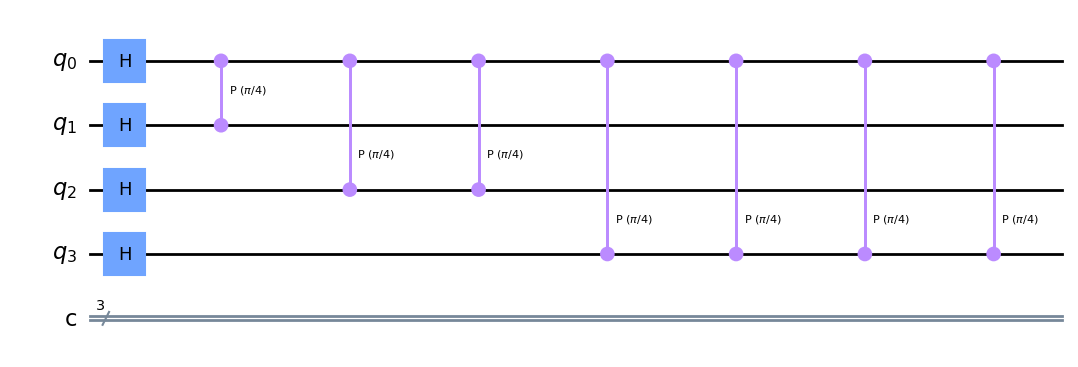

In [22]:
m=3
n=1
qpe = QuantumCircuit(n+m,m)

qpe.h(0)

qpe.h(range(1,n+m))

for ind in range(m):
    for j in range(2**ind):
        qpe.cp(np.pi/4,0,ind+1)

qpe.draw("mpl")

Ahora definimos la siguiente funcion que construye la QFT inversa para aplicarla a los $m$ ultimos qubits de un circuito de $n+m$ qubits:

In [23]:
def qft_dagger(qc, n, m):
    """n-qubit QFTdagger the m qubits in circ that are located after n qubits"""
    # Don't forget the Swaps!
    for qubit in range(m//2):
        qc.swap(n+qubit, n+m-qubit-1)
    for j in range(m):
        for k in range(j):
            qc.cp(-math.pi/float(2**(j-k)), n+k, n+j)
        qc.h(n+j)

Finalmente en nuestro de circuito de calculo de la QPE :

*   Ponemos una barrera
*   Añadimos el circuito de la QFT Inversa
*   Ponemos otra barrera y añadimos las puertas de medida
*   Dibujamos el circuito en una sola linea

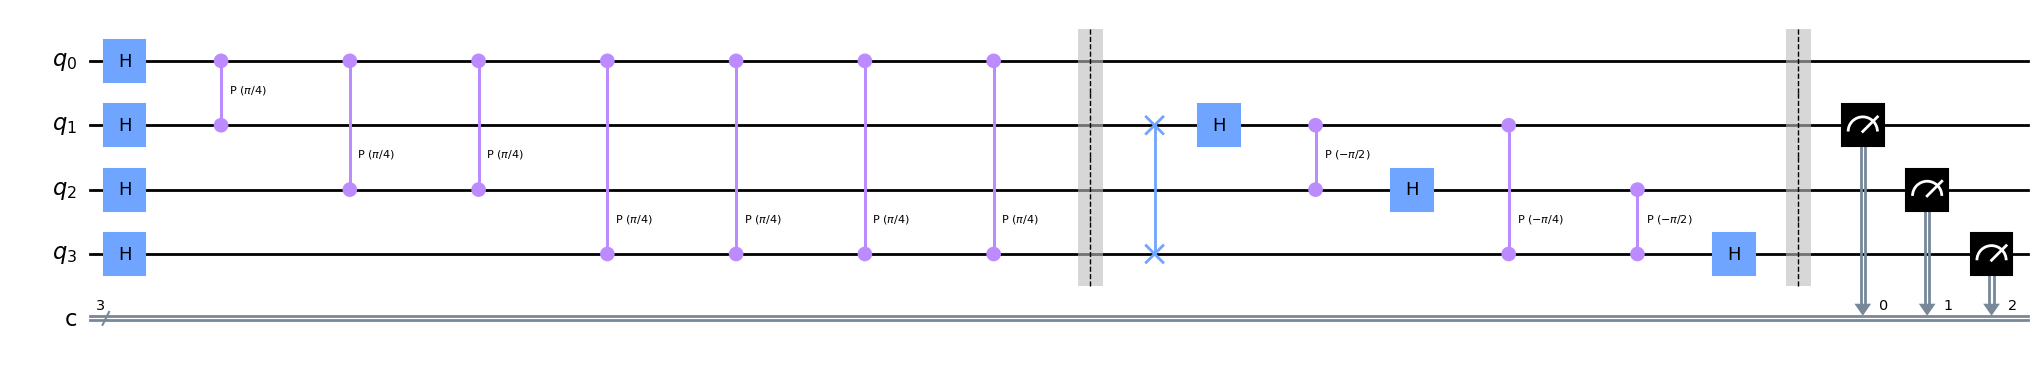

In [24]:
#barrier
qpe.barrier()

# Apply inverse QFT
qft_dagger(qpe,n,m)

# Measure
qpe.barrier()
qpe.measure(range(1,n+m),range(m))

qpe.draw("mpl",fold=-1)


Ahora ejecutaremos el circuito y obtendremos la medida en el registro contador auxiliar

Obten el histograma de medidas en numerico y visualizandolo en una figura

resultado -- cuenta
000      -- 508
001      -- 516


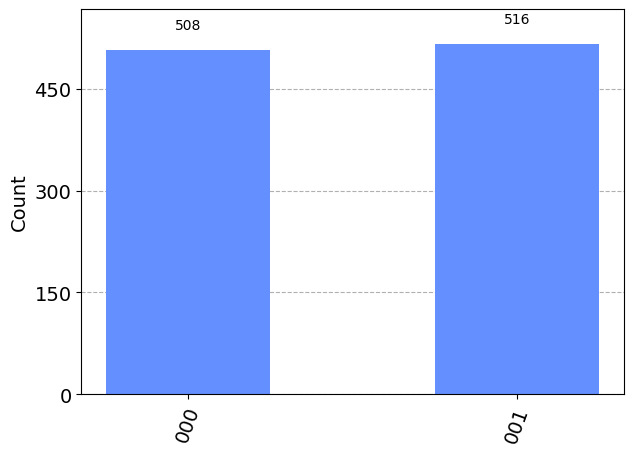

In [25]:
# Hacemos un transpile del circuito para el simulador
simulador = Aer.get_backend("aer_simulator")
tcirc = transpile(qpe,simulador)

# lo corremos y obtenemos los resultados
job = simulador.run(tcirc)
resultados = job.result()

#print numeric results con la funcion count_to_digital_values
count_to_digital_values(resultados.get_counts())
display(plot_histogram(resultados.get_counts()))

Vemos que debemos de obtener es (`001`) con total certeza, lo que se traduce al decimal: `1`. Ahora necesitamos dividir nuestro resultado (`1`) por $2^m$ para obtener el resultado exacto de $\theta$:

$$ \theta = \frac{1}{2^3} = \frac{1}{8} $$

En este caso, hemos obtenido el resultado exacto porque $\theta$ es un numero entero.

### EJERCICIO

En lugar de una puerta $T$, usemos otra puerta de un qubit, la puerta $P(\frac{2\pi}{3})$  de rotacion con un angulo $\theta = \frac{1}{3}= 0.333$. El vector propio de este operador que es |1>.

Crea el circuito y mide los resultados de estimacion de fase tomando $m=3$ como numero de qubits en el registro de conteo

En este caso $2^m \theta=2.666$ no es un numero entero, por lo que no vamos a poder medir con total certidumbre la fase.

/home/codespace/.python/current/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


resultado -- cuenta
000      -- 17
001      -- 40
010      -- 187
011      -- 695
100      -- 42
101      -- 19
110      -- 11
111      -- 13


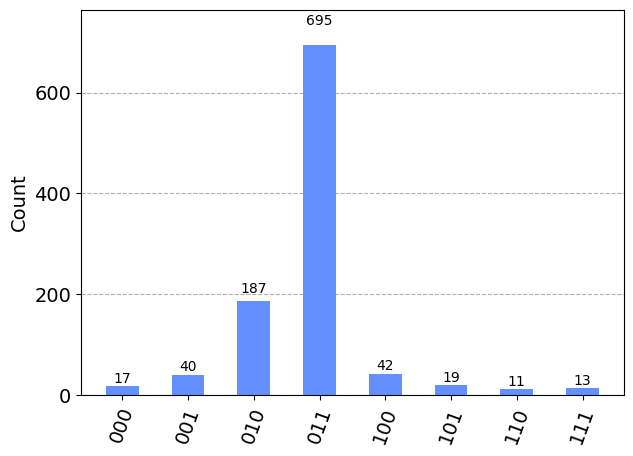

In [26]:
m=3
n=1
angle=2*math.pi/3
qpe = QuantumCircuit(n+m,m)

qpe.x(0)

qpe.h(range(1,n+m))

for ind in range(m):
    for j in range(2**ind):
        qpe.cp(angle,0,ind+1)

#barrier
qpe.barrier()

# Apply inverse QFT
qft_dagger(qpe,n,m)

# Measure
qpe.barrier()
qpe.measure(range(1,n+m),range(m))

qpe.draw("mpl",fold=-1)


# Hacemos un transpile del circuito para el simulador
simulador = Aer.get_backend("aer_simulator")
tcirc = transpile(qpe,simulador)

# lo corremos y obtenemos los resultados
job = simulador.run(tcirc)
resultados = job.result()

#print numeric results con la funcion count_to_digital_values
count_to_digital_values(resultados.get_counts())
display(plot_histogram(resultados.get_counts()))


Estamos esperando el resultado $\theta = 0.3333\dots$, y pero con este circuito tenemos que obtener que nuestros resultados más probables son `010(bin) = 2(dec)` y `011(bin) = 3(dec)`. Estos dos resultados nos dirían que $\theta = 0,25$ (desviación del 25%) y $\theta = 0,375$ (desviación del 13%) respectivamente. El verdadero valor de $\theta$ se encuentra entre los valores que podemos obtener de nuestros bits de conteo, y esto nos da incertidumbre e imprecisión.

### EJERCICIO

Para obtener más precisión, simplemente agregamos más qubits de conteo. Vamos a agregar dos qubits de conteo más, tomando $m=5$

/home/codespace/.python/current/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


resultado -- cuenta
00000      -- 3
00001      -- 2
00011      -- 1
00100      -- 2
00101      -- 2
00110      -- 3
00111      -- 6
01000      -- 13
01001      -- 24
01010      -- 167
01011      -- 704
01100      -- 46
01101      -- 13
01110      -- 6
01111      -- 6
10000      -- 2
10001      -- 3
10010      -- 3
10011      -- 5
10110      -- 1
10111      -- 2
11000      -- 1
11001      -- 1
11011      -- 1
11100      -- 1
11101      -- 1
11110      -- 3
11111      -- 2


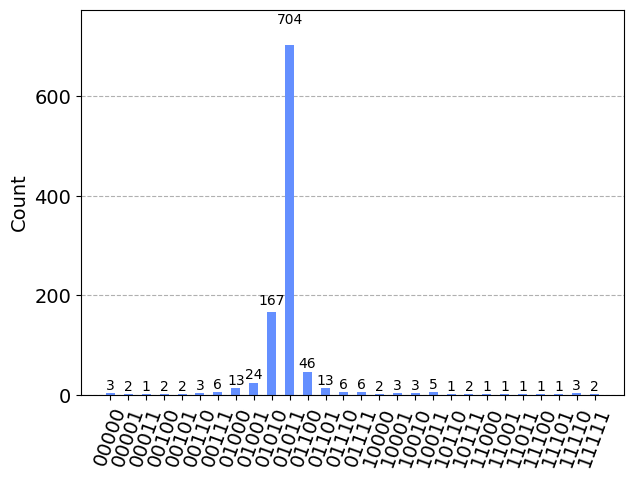

In [27]:
m=5
n=1
angle=2*math.pi/3
qpe = QuantumCircuit(n+m,m)

qpe.x(0)

qpe.h(range(1,n+m))

for ind in range(m):
    for j in range(2**ind):
        qpe.cp(angle,0,ind+1)

#barrier
qpe.barrier()

# Apply inverse QFT
qft_dagger(qpe,n,m)

# Measure
qpe.barrier()
qpe.measure(range(1,n+m),range(m))

qpe.draw("mpl",fold=-1)


# Hacemos un transpile del circuito para el simulador
simulador = Aer.get_backend("aer_simulator")
tcirc = transpile(qpe,simulador)

# lo corremos y obtenemos los resultados
job = simulador.run(tcirc)
resultados = job.result()

#print numeric results con la funcion count_to_digital_values
count_to_digital_values(resultados.get_counts())
display(plot_histogram(resultados.get_counts()))

Las dos medidas más probables que debemos de obtener ahora son  "01011" (11 decimal) y "01010" (10 decimal). Medir estos resultados nos diría que $\theta$ es:

$$
\theta = \frac{11}{2^5} = 0.344,\;\text{ o }\;\; \theta = \frac{10}{2^5} = 0,313
$$

Estos dos resultados difieren de $\frac{1}{3}$ en un 3% y un 6% respectivamente. ¡Una precisión mucho mejor!

## Ejecucion en un Simulador con ruido

### EJERCICIO

Ejecuta el circuito los ejercicios anteriores, donde estimamos la fase de los operadores $T$ y $P(\frac{2\pi}{3})$  en un simulador con ruido

In [ ]:
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit.providers.aer import Aer, AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.fake_provider import FakeVigo

In [ ]:
#qpe T \thta = 1


In [ ]:
#qpe P \theta 1/3


## Ejecucion en un BackEnd cuántico

### EJERCICIO

Ejecuta los circuitos anteriores en Backend cuantico real